# Graph Mask Explainer

In [ ]:
import torch
from torch.nn import ReLU, LogSoftmax
from torch.nn.functional import nll_loss
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import Planetoid

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/cora", name="cora")
data = dataset[0].to(device)

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 64), "x, edge_index -> x"),
    ReLU(inplace=True),
    (GCNConv(64, dataset.num_classes), "x, edge_index -> x"),
    LogSoftmax(dim=1)
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'Training acc: {acc_train:.2f}, test acc: {acc_test:.2f}')

Processing...
Done!


Training acc: 1.00, test acc: 0.81


In [ ]:
from torch_geometric.explain import Explainer, GraphMaskExplainer

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)

node_index = 0
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Train explainer for node(s) tensor([0]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s]
Train explainer for node(s) tensor([0]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 52.34it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 265.25it/s]

Generated explanations in ['node_mask', 'edge_mask']


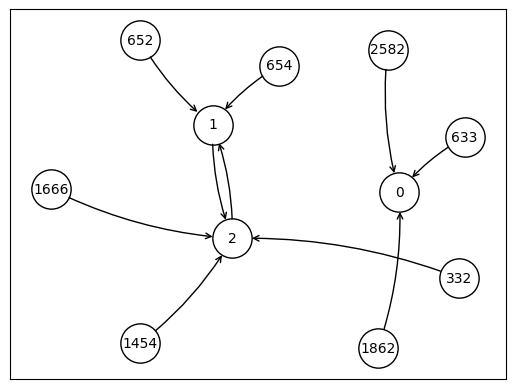

In [ ]:
explanation.visualize_graph(backend="networkx")

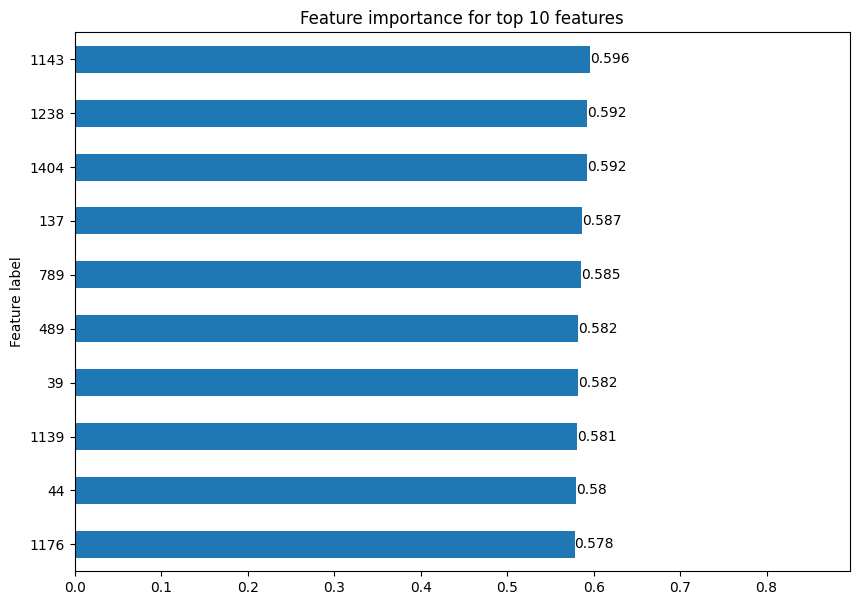

In [ ]:
explanation.visualize_feature_importance(top_k=10)

In [ ]:
import torch
import numpy as np
from torch.nn import ReLU, Sigmoid
from torch.nn.functional import binary_cross_entropy
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import HeterophilousGraphDataset
import os

np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cpu")
dataset = HeterophilousGraphDataset(root="./data/minesweeper", name="minesweeper")
data = dataset[0].to(device)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[(data.y == 1).nonzero(as_tuple=True)] = True
data.train_mask[np.random.choice((data.y == 0).nonzero(as_tuple=True)[0].cpu().numpy(), 4000)] = True

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 8), "x, edge_index -> x"),
    ReLU(inplace=True),
    (GCNConv(8, 1), "x, edge_index -> x"),
    Sigmoid()
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].float().unsqueeze(1))
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index)
acc_train = (pred.round().long()[data.train_mask] == data.y[data.train_mask].unsqueeze(1)).sum().item() / data.train_mask.sum().item()
acc = (pred.round().long() == data.y.unsqueeze(1)).sum().item() / data.num_nodes
print(f'Training acc: {acc_train:.2f}, test acc: {acc:.2f}')

Processing...
Done!


Training acc: 0.68, test acc: 0.74


In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)

node_index = 0
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Train explainer for node(s) tensor([0]) with layer 1: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]
Train explainer for node(s) tensor([0]) with layer 0: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 32.73it/s]

Generated explanations in ['node_mask', 'edge_mask']


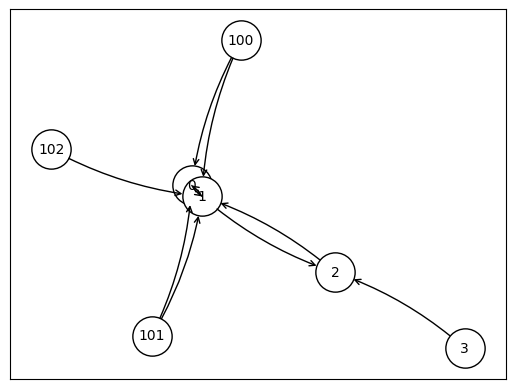

In [ ]:
explanation.visualize_graph(backend="networkx")

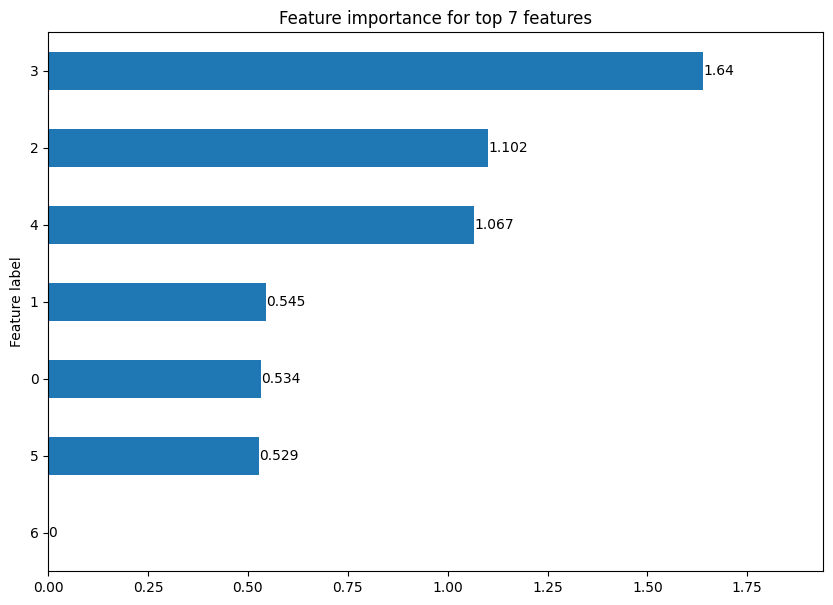

In [ ]:
explanation.visualize_feature_importance(top_k=10)

**GAT**

In [ ]:
from torch_geometric.nn import GATConv, GCNConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8)
        self.conv2 = GATConv(64, dataset.num_classes, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)

node_index = torch.tensor([10, 20])
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Train explainer for node(s) tensor([10, 20]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 34.72it/s]
Train explainer for node(s) tensor([10, 20]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 39.17it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 274.51it/s]

Generated explanations in ['node_mask', 'edge_mask']


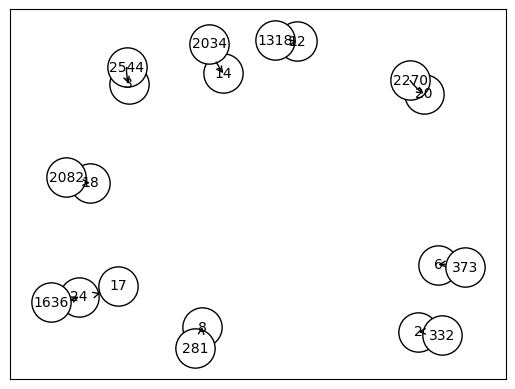

In [ ]:
explanation.visualize_graph(backend="networkx")